In [10]:
import sys
sys.path.append("./Methods")
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
plt.style.use('seaborn')

from download import download_file

class Energy:
    
    def __init__(self):
        self.data = ""
        self.file = False
        download_file()
    
    def download(self):
        self.data = pd.read_csv("./Download/Energy.csv")
        self.data = self.data[self.data["year"]>= 1970]
        self.file = True
        return self.data
    
    def country_list(self):
        '''
        Lists all unique countries that are in the given Energy.csv File in the "country" column
        Parameters
        ------------
        Returns
        ---------
        List of countries in country column. 
        Example
        ---------
        x.country_list()
        with x being an Energy class object.
        '''
        if self.file == False:
            self.download()
        return self.data["country"].unique()
    
    def plot_consumption(self,country: str,normalize: bool):
        if self.file == False:
            self.download()
        if country not in self.data["country"].unique():
            raise ValueError("Variable is not part of the countries in the dataframe.")
        elif normalize == False:
            df2 = self.data[self.data["country"] == country][self.data.columns[self.data.columns.str.contains("_consumption|country|year")]]
        else: #Normalize Data
            values = self.data[self.data["country"] == country][self.data.columns[self.data.columns.str.contains("_consumption")]]
            values = values.fillna(0)
            x_scaled = values.div(values.sum(axis=1), axis=0).reset_index(drop=True)
            df2 = pd.DataFrame(x_scaled,columns=values.columns)
            df2["year"] = self.data[self.data["country"] == country][self.data.columns[self.data.columns.str.contains("_consumption|year|country")]]["year"].reset_index(drop=True)
            df2["country"] = self.data[self.data["country"] == country][self.data.columns[self.data.columns.str.contains("_consumption|year|country")]]["country"].reset_index(drop=True)
        #Plot all consumption 
        liste = []
        for x in df2.columns:
            liste.append(x)
        liste.remove("year")
        liste.remove("country")
        x = df2["year"]
        for y in liste:
            i = df2[y]
            plt.plot(x,i,label = y)
            plt.legend()
    
    #METHOD 4
    def energy_compare(self, countries: list):
        '''
        Takes a list of countries and iterates over it to find the\
        respective value in the dataset for the total energy consumed\

        Appends each country element to loca : list
        Appends each value of that country's consumption to val : list

        Plot a barchart of each country in the list and their\
        energy consumption for the sake of comparison

        Parameters
        ---------------
        countries: list
            list of country strings

        Output
        ---------------
        figure: BarContainer
            compare the total consumption of each country
        '''
        if self.file == False:
            self.download()
        DF_consumption = self.data.filter(like = "_consumption") #get the df of the consumption columns
        DF_country = self.data[["country"]]#get the df of the country column

        #merge the two dfs into 'df' having the columns of country and all the consumptions
        df = pd.merge(DF_country, DF_consumption, left_index = True, right_index = True)

        #group by countries and compute the averge of each consumption over the years
        #'new_df' having index label as country and counsumptions columns
        new_df = df.groupby("country").mean()

        #compute the sum of all consumptions into TOTAL
        new_df["TOTAL_energy_consumption"] = new_df.iloc[:,:].sum(axis = 1)
        final_DF = new_df[["TOTAL_energy_consumption"]]
        FDF = final_DF.reset_index()
        

        loca = []
        val = []
        for country in countries:
            if country not in FDF["country"].tolist():
                raise ValueError(f"Country {country} not on the list of countries")
                return
            e = FDF[FDF["country"] == country]["TOTAL_energy_consumption"].values[0]
            loca.append(country)
            val.append(e)

        fig = plt.figure(figsize = (10, 5))

        plt.bar(loca, val, color ='purple', width = 0.8)

        plt.xlabel("Countries")
        plt.ylabel("Energy Consumption")
        plt.title("Total Energy consumption per Country")
        plt.show()
        
        
        #METHOD 5
    def gdp_compare(self, countries: list):
        '''
        Takes a list of countries and iterates over it to create a\
        dataframe temp : DataFrame for each country and plots\
        the column "gdp" of that country over the years


        Parameters
        ---------------
        countries: list
            list of country strings

        Output
        ---------------
        figure: AxesSubplot
            compare the GDP of each country over the years
        '''
        if self.file == False:
            self.download()
        #create new dataframe made of three columns: "country", "year", and "gdp"
        gdp_DF = self.data[["country", "year", "gdp"]]
        figure, axis = plt.subplots()
        temp = []
        flag = 0
        for country in countries:
            if country not in gdp_DF["country"].tolist():
                raise ValueError(f"Country {country} not on the list of countries")
                flag = 1
                break
            temp.append(gdp_DF[gdp_DF["country"] == country])
            #temp = gdp_DF[gdp_DF["country"] == country]
        if flag == 0:
            for element in temp:
                element.plot(ax = axis, x = "year", y = "gdp", label = country\
                         ,title = "GDP of the years")
            #plt.show()
        
    #METHOD 6
    def gapminder(self, year: int):
        '''
        Takes an argument representing the year\
        if the argument is not an int, raises TypeError, else\
        plots scatter plot for the given year with the x-axis\
        the GDP and y-axis the total consumption. 
        the size of the scatters is proportional to the population

        Parameters
        ---------------
        year: int
            Year where the energy consumptions are summed and plotted

        Output
        ---------------
        figure: ScatterPlot
            In reference to the gapminder tool
        '''
        if self.file == False:
            self.download()
        #'edf' having one column representing the sum of all consumptions per country per year
        edf = self.data.filter(like = "_consumption").sum(axis = 1).to_frame()
        rdf = self.data[["country", "year", "gdp", "population"]]
        gapminder_df = pd.merge(rdf, edf, left_index = True, right_index = True)
        if type(year) not in [int]:
            raise TypeError("variable 'Year' is not an int")
            return
        t = gapminder_df.groupby("year").get_group(year)
        t = t.set_axis(["country", "year", "gdp", "population", "energy"], axis = 1)
        t = t[t["country"] != "World"]
        t["population"] = (t["population"]/1000000).round(2)

        plt.scatter(t["gdp"],t["energy"], s=t["population"], alpha = 0.8)
        plt.xlabel("GDP of countries")
        plt.ylabel("Energy consumption")
        plt.title(f"Gapminder scatter of Energy consumed per GDP of countries in {year}")
        plt.xscale("log")
        plt.yscale("log")
        plt.show()

In [11]:
x = Energy()

File already exists !


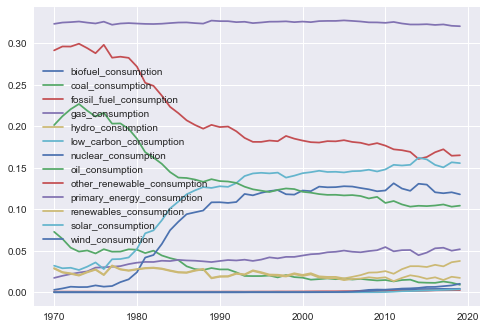

In [12]:
x.plot_consumption("France",normalize=True)

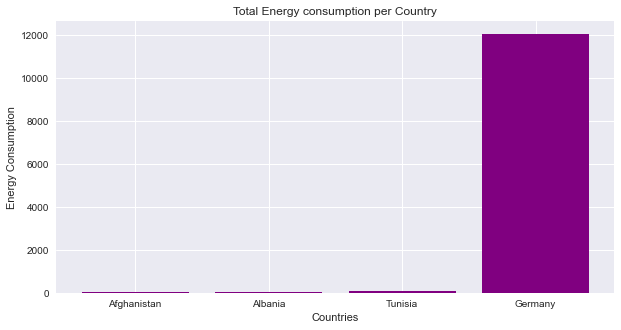

In [3]:
x.energy_compare(["Afghanistan", "Albania", "Tunisia", "Germany"])

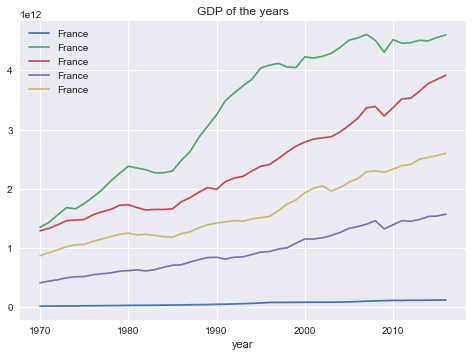

In [4]:
x.gdp_compare(["Tunisia", "Japan", "Germany", "Canada", "France"])

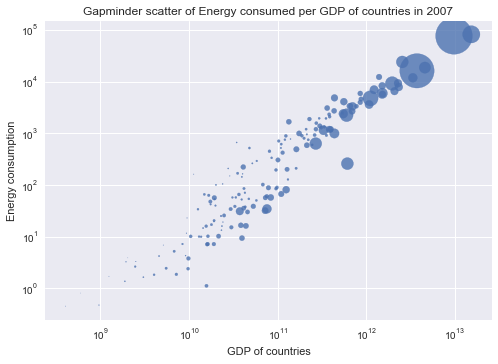

In [5]:
x.gapminder(2007)

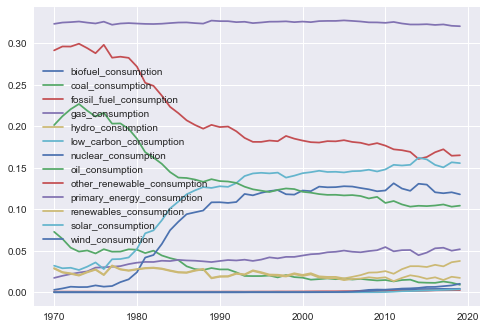